# Assignment 1
#### Social data analysis and visualization 02806
#### Technical University of Denmark

For the peergrader, please make sure your CSV file for the SFPD dataset is in the same directory as this notebook if you for some reason need to re-run

In [57]:
# This cell is included to show what libraries are imported and used in the assignment
import csv
import urllib2
import matplotlib.pyplot as plt
import numpy as np
import geoplotlib
import random

from geoplotlib.utils import BoundingBox
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors, datasets
from scipy import stats

%matplotlib inline

## Assignment 1A: Anscombe's quartet

__Start by downloading these four datasets: Data 1, Data 2, Data 3, and Data 4. The format is .tsv, which stands for tab separated values. Each file has two columns (separated using the tab character). The first column is x-values, and the second column is y-values.__

We use the urllib2 package to download all the __.tsv__ files and then we load them into numpy arrays

In [58]:

baseUrl = "https://raw.githubusercontent.com/suneman/socialdataanalysis2017/master/files/"
data = []
# Load the data
for i in range(1,5):
    url = baseUrl+"data%d.tsv" % i
    data.append(urllib2.urlopen(url))

# Load the txt into numpy
nData = []
for i in data:
    nData.append(np.loadtxt(i))

    

Next it's time to calculate the summary statistics and the linear regression for all 4 datasets. 

All of the statistics can be calculated using the built in numpy functions such as __var__, __mean__ and __corrcoef__ for correlation coefficient. 

The linear regression is calculated using scipy's __linregress__ function. And we remember that the function for a linear function is given as $ f(x) = ax + b $

Statistics for data1.tsv
Mean: 
 x:       9.00 
 y:       7.50
Variance 
 x:     10.000 
 y:      3.752
Pearson Correlation 
 cor:    0.816
Linear Regression
 a:       0.50
 b:       3.00
 f(x) = 0.50x + 3.00


Statistics for data2.tsv
Mean: 
 x:       9.00 
 y:       7.50
Variance 
 x:     10.000 
 y:      3.752
Pearson Correlation 
 cor:    0.816
Linear Regression
 a:       0.50
 b:       3.00
 f(x) = 0.50x + 3.00


Statistics for data3.tsv
Mean: 
 x:       9.00 
 y:       7.50
Variance 
 x:     10.000 
 y:      3.748
Pearson Correlation 
 cor:    0.816
Linear Regression
 a:       0.50
 b:       3.00
 f(x) = 0.50x + 3.00


Statistics for data4.tsv
Mean: 
 x:       9.00 
 y:       7.50
Variance 
 x:     10.000 
 y:      3.748
Pearson Correlation 
 cor:    0.817
Linear Regression
 a:       0.50
 b:       3.00
 f(x) = 0.50x + 3.00




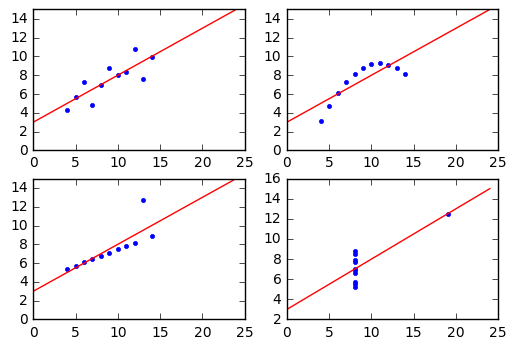

In [59]:
# Calculate statistics and plot
for idx,data in enumerate(nData):
    # Even though the mean is the same for all 4 datasets, printing to 16+ decimals shows otherwise
    print("Statistics for data%s.tsv" % str(idx + 1))
    print("Mean: \n x: %s \n y: %s" % ("{:10.2f}".format(np.mean(data,axis=0)[0]),
                                       "{:10.2f}".format(np.mean(data,axis=0)[1])))
    
    print("Variance \n x: %s \n y: %s" % ("{:10.3f}".format(np.var(data,axis=0)[0]),
                                          "{:10.3f}".format(np.var(data,axis=0)[1])))
    print("Pearson Correlation \n cor: %s" % "{:8.3f}".format(np.corrcoef(data[:,0], data[:,1])[0, 1]))
    
    print("Linear Regression")
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[:,0],data[:,1])
    print(" a: {:10.2f}".format(slope))
    print(" b: {:10.2f}".format(intercept))
    print(" f(x) = %sx + %s" % ("{:4.2f}".format(slope), "{:4.2f}".format(intercept)))

    x = np.array(range(0,25))
    
    #Linear function f(x) = ax+b
    y = x*slope+intercept
    plt.axis([0,25,0,15])
    plt.subplot(2,2,idx+1)
    
    plt.plot(data[:,0], data[:,1],'.')
    plt.plot(x, y,'red')
    
    print("\n")
    
#Show the subplots 
plt.show()


<span style="color: red; font-size:18px"> The point of the exercise </span>

As we can see all of the above statistics are very similar, and impossible to tell apart if only using 2 decimals of precision. One might draw the conclusion that the 4 dataset are very similar or even identical, because their summary statistics are equal. However as we can see this is wrong. Without visualisation it's impossible (with these statistics) to grasp what the data is like. When we plot it we can see what the data is actually like, and the datasets are in fact all very different even though the summary statistics says otherwise. 


## Assignment 1B: KNN

This assignment considers the K-nearest neighbors method. We will import the San Francisco Police Department crime records from January 1st 2003 to todays date. We will keep the data in a python __dict__ of lists where each entry in the list corresponds to a crime incident. 

In [60]:
with open('SFPD_Incidents_-_from_1_January_2003.csv','r') as infile:
    
    focuscrimes = ['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY',
                   'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT',
                   'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT']
    
    data = {
                "lat": [],
                "lon": [],
                "Category": [],
                "Date": [],
                "Time": [],
                "PdDistrict": []     
    }
    
    for line in csv.DictReader( infile, delimiter=","):
        try:
            data["lat"].append(float(line["Y"]))
            data["lon"].append(float(line["X"]))
            data["Category"].append(line["Category"])
            data["Date"].append(line["Date"])
            data["Time"].append(line["Time"])
            data["PdDistrict"].append(line["PdDistrict"])
        except:
            print(line)

__Begin by using geoplotlib to plot all incidents of the three crime types on their own map using geoplotlib.kde(). This will give you an idea of how the varioius crimes are distributed across the city.__

First we divide the data into the three crime types, and count how many incidents are in each group

In [61]:
#Bounding box, defined using google maps
x_min = -122.595317
x_max = -122.286379
y_max = 37.8325
y_min = 37.7040

#Initialize the three groups of categories
prostitution_geo = {
    "lat": [],
    "lon": []
}
drug_geo = {
    "lat": [],
    "lon": []
}
driving_geo = {
    "lat": [],
    "lon": []
}

focuscrimes_knn = ['PROSTITUTION', 'DRUG/NARCOTIC', 'DRIVING UNDER THE INFLUENCE']

#Divide the original data into the three focuscrimes so we can plot it
for idx in range(len(data["Category"])):
    if(data["Category"][idx] == focuscrimes_knn[0]):
        prostitution_geo["lat"].append(data["lat"][idx])
        prostitution_geo["lon"].append(data["lon"][idx])
    if(data["Category"][idx] == focuscrimes_knn[1]):
        drug_geo["lat"].append(data["lat"][idx])
        drug_geo["lon"].append(data["lon"][idx])
    if(data["Category"][idx] == focuscrimes_knn[2]):
        driving_geo["lat"].append(data["lat"][idx])
        driving_geo["lon"].append(data["lon"][idx])

#Print the size of each category
print("Number of crimes in each category: \nProstitution: %d \nDrug/Narcotic: %d \nDriving Under The Influence: %d \n" %
        (len(prostitution_geo["lat"]), len(drug_geo["lat"]), len(driving_geo["lat"])))

Number of crimes in each category: 
Prostitution: 16164 
Drug/Narcotic: 115200 
Driving Under The Influence: 5308 



Now lets use Geoplot lib to plot all three crimetypes to see how they are distributed.

In [62]:
#Set up a bounding box:
bbox = BoundingBox(north=y_max, west=x_min, south=y_min, east=x_max)

#Plot the 3 different crime using Kernel Density Estimation
geoplotlib.kde(prostitution_geo, bw=6, cut_below=1e-4)
geoplotlib.set_bbox(bbox)
print("Prostitution Crimes")
geoplotlib.inline()

geoplotlib.kde(drug_geo, bw=6, cut_below=1e-4)
geoplotlib.set_bbox(bbox)
print("Drug/Narcotic Crimes")
geoplotlib.inline()

geoplotlib.kde(driving_geo, bw=6, cut_below=1e-4)
geoplotlib.set_bbox(bbox)
print("Driving under the influence Crimes")
geoplotlib.inline()

Prostitution Crimes
('smallest non-zero count', 4.9755799111408007e-10)
('max count:', 8.4612274394437748)


Drug/Narcotic Crimes
('smallest non-zero count', 4.9755799111408007e-10)
('max count:', 32.630807669846597)


Driving under the influence Crimes
('smallest non-zero count', 4.9755799111408007e-10)
('max count:', 0.46506506085568061)


__Next, it's time to set up your model based on the actual data. You can use the code supplied in the book or try out scikit-learn's KNeighborsClassifier. __

> We use the KNeighborsClassifier from scikit-learn as recommended

__ Since the algorithm classifies each point according to it's neighbors, what could a consequence of this imbalance in the number of examples from each class mean for your map? __

As we saw earlier the three categories are imbalanced. With the follow distribution:

* Prostitution: 16164 
* Drug/Narcotic: 115200 
* Driving Under The Influence: 5308 

But from the maps we also see that the data is spread out differently. Prostitution and Drug/Narcotis are both heavily centered around their respective areas, while Driving Under The Influence is more evenly spread out. A consequence could be an overrepresentation of Prositution classes, and an under representation of Driving under the influence. To mitigate this we do an equal classes approach. We put 5000 incidents in each class and we make sure sampling is randomized by shuffling the lists.

__ How do you expect that will change the KNN result? In which situations is the balanced map useful - and when is the map that data in proportion to occurrences useful? __

We believe this __balanced__ approach will change the KNN result to have more Driving under the Influence predictions as they were more uniformly distributed in the KDE plot. If we did not balance the data it could be that you would be extrapolating the prostituion and narcotic crimes out of their respective areas. The KDE plots suggests that these two crime types occurs in very specific areas of the city. 

Let's test this out in practice by setting up our data for the KNN classifier:

In [63]:
# KNN classifier takes an X and a Y list
# X is the coordinates of our data. Where a coordinate is a list containing lat / long
# Y is the corresponding labels (category). Y is a vector


X = []
Y = []

#Size of each category (Picked such the the smallest category still fits within)
size = 5000

#Shuffle the lists to make sure sampling is random
#Do pairwise shuffling so coordinates are kept together
combined = list(zip(prostitution_geo["lat"], prostitution_geo["lon"]))
random.shuffle(combined)
prostitution_geo["lat"][:], prostitution_geo["lon"][:] = zip(*combined)

combined = list(zip(drug_geo["lat"], drug_geo["lon"]))
random.shuffle(combined)
drug_geo["lat"][:], drug_geo["lon"][:] = zip(*combined)

combined = list(zip(driving_geo["lat"], driving_geo["lon"]))
random.shuffle(combined)
driving_geo["lat"][:], driving_geo["lon"][:] = zip(*combined)

#Build the X and Y lists
for idx in range(size):    
    lat = prostitution_geo["lat"][idx]
    lon = prostitution_geo["lon"][idx]
     
    if(lat > 40): #One datapoint of "lat" is 90.0 so lets remove it
        continue

    X.append([prostitution_geo["lat"][idx],prostitution_geo["lon"][idx]])
    Y.append("PROSTITUTION")
for idx in range(size):
    lat = drug_geo["lat"][idx]
    lon = drug_geo["lon"][idx]
    
    if(lat > 40): #One datapoint of "lat" is 90.0 so lets remove it
        continue
   
    X.append([drug_geo["lat"][idx],drug_geo["lon"][idx]])
    Y.append("DRUG/NARCOTIC")
for idx in range(size):
    lat = driving_geo["lat"][idx]
    lon = driving_geo["lon"][idx]
    
    if(lat > 40): #One datapoint of "lat" is 90.0 so lets remove it
        continue
    
    X.append([driving_geo["lat"][idx],driving_geo["lon"][idx]])
    Y.append("DRIVING UNDER THE INFLUENCE")

There is a coordinate where the latitude is set to 90.0. This is obviously wrong, so to get a meaningful plot we remove it. 

Now the data is divided into an X and a Y set where:

* X is a list of lists where each list is a coordinate pair.
* Y is a list containing the corresponding category labels

Now we fit the KNN classifier on our data, and create a meshgrid with an equal distance $ h $ to each point. Then we store the predicted values for three different values of $k$ 5, 10 and 30 neighbors

In [64]:
#Number of neighbours for KNN
k_values = [5,10,30]
Z_values = []
for k in k_values: 
    #Setup the KNN classifier
    h = .001 # step size in the mesh, chosen arbitrarily
    knn=neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')

    # we create an instance of Neighbours Classifier and fit the data.
    knn.fit(X, Y)

    #Create the meshgrid such that there is an equal "h" distance between each point
    xx, yy = np.meshgrid(np.arange(y_min, y_max, h), np.arange(x_min, x_max, h))


    #run the prediction (assign predicted labels)
    Z_values.append(knn.predict(np.c_[xx.ravel(), yy.ravel()]))
    
print("Gridsize is %d x %d " % (len(xx),len(yy)))

Gridsize is 309 x 309 


We pick a step size of .001 which gives us a gridsize of 309x309. Notice we could have picked this number to be lower if we wanted a finer grid, or higher for a courser grid. 

Next we re-package the data so we can plot it using geoplotlib.

In [65]:
print("KNN analysis with equal classes (5000)")
print("Plotting KNN with k-values of 5,10 and 30 in that order")

#plot a map for 5,10 and 30 neighbors
for Z in Z_values:
    ## re-build the KNN classes to work with geoplotlib
    knn_pros = {
        "lat":[],
        "lon":[]
    }
    knn_drug = {
        "lat":[],
        "lon":[]
    }
    knn_drive =  {
        "lat":[],
        "lon":[]
    }
    count = 0
    for row in range(len(xx)):
        for col in range(len(xx[0])):
        
            if(Z[count] == "PROSTITUTION"):
                knn_pros["lat"].append(xx[row][col])
                knn_pros["lon"].append(yy[row][col])
            
            if(Z[count] == "DRUG/NARCOTIC"):
                knn_drug["lat"].append(xx[row][col])
                knn_drug["lon"].append(yy[row][col])
            
            if(Z[count] == "DRIVING UNDER THE INFLUENCE"):
                knn_drive["lat"].append(xx[row][col])
                knn_drive["lon"].append(yy[row][col])
            count+=1
    #Plot the KNN-prediction classes
    #Pick a different color for each class, and hold the plot until all classes has been plotted
    geoplotlib.dot(knn_pros,color=[255,0,0,150])
    geoplotlib.dot(knn_drug,color=[0,255,0,150])
    geoplotlib.dot(knn_drive,color=[0,0,255,150])
    geoplotlib.inline()

KNN analysis with equal classes (5000)
Plotting KNN with k-values of 5,10 and 30 in that order


__Describe what happens to the map as you increase the number of neighbors, K.__

When we increase the number of neighbors we get less "noise" in the plot, although the clusters gets more washed out and it's more difficult to distinguish the boundaries of the classes. Since we have not tested the model it's hard to say which value of K is the best. One could use a 10-fold cross validation setup to pick the value of k that minimizes the error. By comparing the initial KDE plots to the KNN ones we think a value for K somewhere between 10 and 30 is fitting. 

We also see that the KNN classifier predicts Prostitution and Narcotic incidents in roughly the same areas as where indicated by the KDE plots, and then Driving under the Influence in a lot of the other areas. This seems realistic as the KDE plots for Prostitution and Narcotics where very centered around a few spots in the city, while driving was very spread out. 

Note that we have trained the KNN model with all of our datapoints and tested it with none. So this is just a visualization of the predictor, since we were not overly concerned with the accuracy. 

## Assignment 1C: Linear Regression

*__Start by picking an area and a crime type, I recommend starting with all of SF and LARCENY/THEFT so you don't have too many zero counts. Similarly, I recommend using 2015 data for training.__*

In [66]:
# The chosen area considered in the last three parts. (The area variable is only used for plotting)
area = "ALL DISTRICTS"
# The chosen crime type considered in the last three parts.
crime_type = 'LARCENY/THEFT'
# The years used for the training set.
yrs = [2015]

# Create a list for time-of-day (in the range 05:00-17:00) to be used on the xx-axis.
hrs = range(5,17)

*__We start by creating a scatterplot.__*

We will create a scatterplot to show the chosen data for the assignment. We have chosen to work with the recommended data. However the python code is designed so it is easy to try some other training sets (other years, other crime types).

*__Go over the training data and bin and observed number of LARCENY/THEFT crimes per hour. You should have 12 data-points per day of training data.__*

We will create a data structure to store crime counts for all dates in the data set. It will be a dictionary of lists. The dictionary can be accessed with a date which will return a list. This list is the time bins for each hour in the time interval. The indices in the list corresponds to an hour in the time interval and the list element is the crime count for that hour.

In [67]:
# Initialize a dictionary of lists (a list for each day) for bins corresponding to each hour in time interval
bins = {date: [0 for hr in range(5,17)] for date in set(data["Date"])}

# Go through training data set
for idx in range(len(data["Time"])):
    # Get hour and date of crime incident
    hr = int(data["Time"][idx].split(":")[0])
    date = data["Date"][idx]
    # Check if crime type and hour corresponds with chosen crime and time interval
    if crime_type == data["Category"][idx] and hr in hrs:
        # Increment bin of the hour, elements are zero-indexed so we subtract 5 to enter list
        bins[date][hr-5] += 1

In [68]:
# Here we print a small part of the bins data structure.
example_dates = ['11/05/2009', '10/04/2013', '09/17/2014', '01/22/2008', '04/24/2005']

for date in example_dates:
    print date + ": " + str(bins[date])

11/05/2009: [0, 1, 2, 2, 3, 1, 1, 6, 1, 3, 8, 3]
10/04/2013: [1, 4, 0, 4, 6, 5, 3, 6, 8, 6, 6, 10]
09/17/2014: [0, 1, 1, 1, 4, 4, 5, 5, 3, 3, 8, 9]
01/22/2008: [0, 1, 1, 4, 2, 1, 7, 3, 5, 6, 8, 2]
04/24/2005: [0, 0, 0, 0, 0, 4, 6, 2, 3, 3, 1, 2]


In [69]:
# How many days in the training set
num_days = 0
for date in bins:
    # Extract year of the date
    yr = int(date.split("/")[2])
    if yr in yrs:
        num_days += 1
        
print "Number of days in training set: " + str(num_days)

Number of days in training set: 365


In [70]:
# Create data points for scatter plot
data_points = [[], []] #Two lists, one to contain all hours (x-values) and one to contain all crime counts (y-values)

for date in bins:
    # Extract year of the date
    yr = int(date.split("/")[2])
    for hr,count in enumerate(bins[date]):
        # If year is in list of years used for the training set, add data point
        if yr in yrs:
            data_points[0].append(hr+5) #hr is the index so we add 5 to get the correct hour of the time interval
            data_points[1].append(count)
            
print "Number of data points: " + str(len(data_points[0]))

Number of data points: 4380


*__Plot the (time-of-day, bin-count) tuples. Does it look like there is a correlation?__*

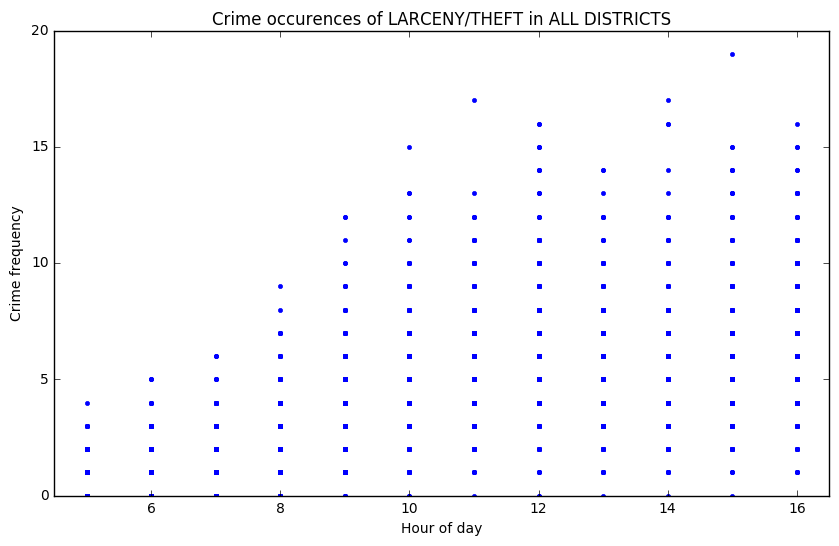

In [71]:
# Plot the (time-of-day, bin-count) tuples
plt.figure(figsize=(10, 6))
plt.plot(data_points[0], data_points[1], '.')
plt.xlabel('Hour of day')
plt.ylabel('Crime frequency')
plt.axis([min(hrs)-0.5, max(hrs)+0.5, 0, max(data_points[1])+1])
plt.title('Crime occurences of %s in %s' % (crime_type, area))

The crime count for this specific crime does seem to be have some correlation with the hours of the chosen time interval. Of course there also are many different crime count values for each time bin but there is some kind of increasing quality about the data. It is steadily increasing during the hours and it looks there more or less is a constant slope. This suspicion is supported by the pearson correlation coefficient between the two (can be seen below). It is clearly positive meaning that if one variable increases the other will too.

*__Report the Pearson-correlation.__*

In [72]:
# Compute the Pearson-correlation using numpy
pear_corr = np.corrcoef(data_points[0], data_points[1])[0, 1]
print "The pearson correlation between the hours of the time interval and crime count is: " + str(pear_corr)

The pearson correlation between the hours of the time interval and crime count is: 0.632767134957


*__Fit this model to the data (and report $\alpha$, $\beta$).__*

In [73]:
# Now we can fit a straight line to the data.

# First create training data using data points.
# In the linear regression the input features will simply be the hours (time of day).
# The output is the crime count.
X_train = np.matrix(data_points[0]).transpose() #Numpy matrix containing input features

y_train = np.matrix(data_points[1]).transpose() #Numpy matrix containing output features

# Create linear regression object
simple_regr = linear_model.LinearRegression()

# Train the model using the training sets
simple_regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [74]:
# The coefficients of simple regression model
print "Coefficients in regression model"
print "Alpha: " + str(simple_regr.intercept_[0])
print "Beta: " + str(simple_regr.coef_[0][0])

Coefficients in regression model
Alpha: -1.68252706198
Beta: 0.566241977201


*__Add the straight line to your scatterplot.__*

Now we have fitted the regression model to the training set using **scikit learn** and the python object "simple_regr" contains the model. We can make prediction with this model using the ".predict" command.

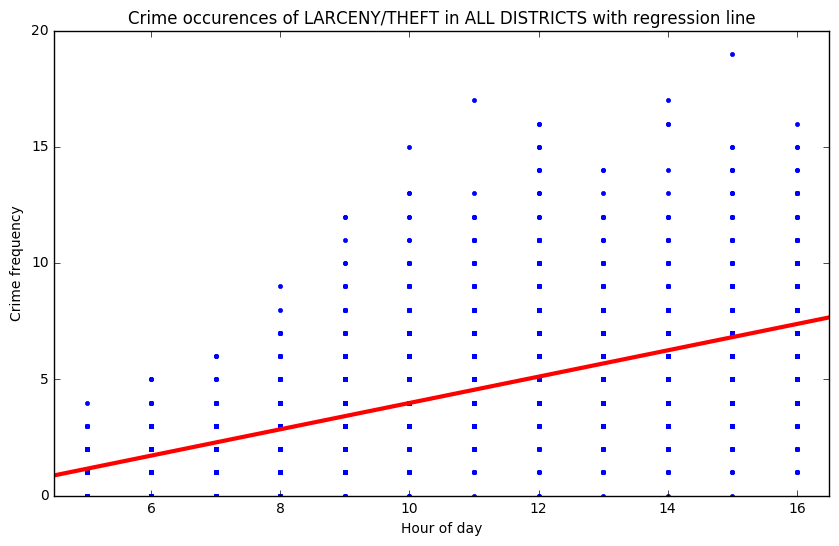

In [75]:
# Plot the (time-of-day, bin-count) tuples with regression line
plt.figure(figsize=(10, 6))
plt.plot(data_points[0], data_points[1], '.')
plt.plot(range(4,18), simple_regr.predict(np.matrix(range(4,18)).transpose()), color='red', linewidth=3)
plt.xlabel('Hour of day')
plt.ylabel('Crime frequency')
plt.axis([min(hrs)-0.5, max(hrs)+0.5, 0, max(data_points[1])+1])
plt.title('Crime occurences of %s in %s with regression line' % (crime_type, area))

plt.show()

As expected the line has a positive slope. There seems to be a lot of points above the line but this is caused by the fact that the many points below is right on top of each other, so they are not all visible in the plot.

## Assignment 1D: Multiple Regression

*__Explain in your own words the reasoning between the two bullets above.__*  

As mentioned in the assignment description and the textbook it is important that the input variables are not correlated when using multiple features. By transforming the total crime count, which is defintely correlated with time-of-day, we can make sure that the second input feature to the model is independent from the first. The question is then whether or not the new second feature will be correlated with crime count and improve the linear regression model. If the effective number of crimes can improve the model, it should have a better performance when predicting crime counts.  

The second bullit point is about rescaling the data. It's smart to rescale the input variables when using multiple features because it let us avoid extreme values of the coefficients in the model. If the data values are very small for one feature but very large for another it could result in a relatively big $\beta$ value, which will basically render small $\beta$'s for other variables useless. So for good measure we rescale all input features to the same range.

*__Start by preparing your data as described in Point 1 and 2.__*

*__Point 1__*

In [76]:
# Compute average number of crimes for each for the chosen time interval
c_avg = [0 for hr in range(5,17)] #Initialize list with average for each time bin

# Compute averages one time bin at a time
for i in range(len(c_avg)):
    # Go through all dates
    for date in bins:
        # Extract year of the date
        yr = int(date.split("/")[2])
        # If year is in list of years used for the training set, add crime count for the date to total count
        if yr in yrs:
            c_avg[i] += bins[date][i]
    # Calculate average
    c_avg[i] /= float(num_days)
    
print "Crime count averages for time bins:"
for idx in range(len(c_avg)):
    print '{:10.3f}'.format(c_avg[idx])

Crime count averages for time bins:
     0.748
     1.167
     1.586
     2.704
     3.742
     5.049
     5.523
     6.490
     5.715
     5.584
     6.195
     6.652


In [77]:
# Compute the effective number of crimes for each observation (each data point in training set)
c_eff = [] #List with number of elements equal to number of data points

# Go through observed crime counts (stored in data_points) and find c_eff
# Go through data_points so indices for incidents is correct
for idx,time_bin in enumerate(data_points[0]):
    c_eff_idx = c_avg[time_bin-5] - data_points[1][idx]
    c_eff.append(c_eff_idx)
    
# Add the effective number of crimes for each observation to data_points, i.e. add them as input features
data_points.append(c_eff)

In [78]:
# Here we show the first 10 c_eff values
for idx in range(10):
    print '{:10.3f}'.format(data_points[2][idx])

    -0.252
    -1.833
     1.586
    -3.296
    -2.258
     4.049
    -5.477
     0.490
     1.715
    -4.416


In [79]:
# Test to see if input features are correlated
pear_corr = np.corrcoef(data_points[0], data_points[2])[0, 1]
print "The pearson correlation between time-of-day and effective number of crimes is: " + str(pear_corr)

The pearson correlation between time-of-day and effective number of crimes is: 3.13625264118e-17


The pearson correlation coefficient for the two input features are approximately zero which indicates no correlation between the variables. This mean that an important requirement about the multiple regression model will be fulfilled, and we can fit the data to a model.

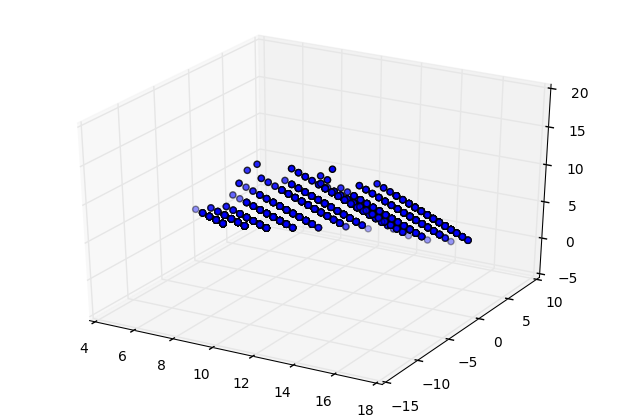

In [80]:
# THIS CELL SHOULD MAYBE NOT BE INCLUDED NICOLAI
import pylab
from mpl_toolkits.mplot3d import Axes3D

fig = pylab.figure()
ax = Axes3D(fig)

ax.scatter(data_points[0], data_points[2], data_points[1])
plt.show()

*__Point 2__*

In [81]:
# Rescale the hours and effective number of crimes for each observation

# We use a rescaling tool from the scikit learn library in python
scaler = preprocessing.MinMaxScaler()

# Here we both input features (the scaler will as default scale data to range [0,1])
data_points_scaled = [scaler.fit_transform(data_points[0]), scaler.fit_transform(data_points[2])]

C:\Users\Urban\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Urban\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Urban\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

In [82]:
# Here we show the first 12 scaled input features in the data points
for idx in range(12):
    print str('{:10.3f}'.format(data_points_scaled[0][idx])) + " " + str('{:10.3f}'.format(data_points_scaled[1][idx]))

     0.000      0.651
     0.091      0.569
     0.182      0.746
     0.273      0.493
     0.364      0.547
     0.455      0.873
     0.545      0.380
     0.636      0.689
     0.727      0.753
     0.818      0.435
     0.909      0.726
     1.000      0.542


*__Fit the data using multiple regression. Report $\alpha$, $\beta_1$, $\beta_2$.__*

In [83]:
# First create training data using hours in time interval, effective number of crimes and crime counts
# In this regression there are two input features (time of day, c_eff)
# The output is the crime count
X2_train = np.matrix([data_points_scaled[0],data_points_scaled[1]]).transpose()

y_train = np.matrix(data_points[1]).transpose()

# Create linear regression object (We normalize/rescale the input features in the regression)
multi_regr = linear_model.LinearRegression()

# Train the model using the training sets
multi_regr.fit(X2_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
# The coefficients of multiple regression model
print "Coefficients in regression model"
print "Alpha: " + str(multi_regr.intercept_[0])
print "Beta: " + str(multi_regr.coef_[0])

Coefficients in regression model
Alpha: 13.9541622761
Beta: [  6.22866175 -19.29589041]


## Assignment 1E: Simple evaluation of regression models

*__We test on two separate weeks of data from 2016. We use the first 7 days (Week A) of January 2016 and first 7 days of June 2016 (Week B).__*

In [85]:
# First extract the bins (crime counts) for the days in weeks A and B
test_days = range(1,8)
test_months = [1, 6]
test_yrs = [2016]

# Initialize the same kind of data structure as bins but only for test dates
test_bins = {}
# Go through all dates
for date in bins:
    # Extract day, month and year of the date
    day = int(date.split("/")[0])
    month = int(date.split("/")[1])
    yr = int(date.split("/")[2])
    # If the date is one of the test dates add crime count bins to test_bins
    if day in test_days and month in test_months and yr in test_yrs:
        test_bins[date] = bins[date]
        
# Create two test sets. Each of these list of lists correspond to data_points used earlier.
test_A = [[], []]; test_B = [[], []]

# Go through all test dates
for date in test_bins:
    # Extract month of the test date
    month = int(date.split("/")[1])
    for hr,count in enumerate(test_bins[date]):
        # If the months is January add hour and crime count to set A
        if month == 1:
            test_A[0].append(hr+5) #hr is the index so we add 5 to get the correct hour of the time interval
            test_A[1].append(count)
        # If the months is June add hour and crime count to set A
        elif month == 6:
            test_B[0].append(hr+5) #hr is the index so we add 5 to get the correct hour of the time interval
            test_B[1].append(count)

In [86]:
# Compute the effective number of crimes for test sets
c_eff_A = []; c_eff_B = [] #Lists with number of elements equal to number of data points

# Go through observed crime counts (stored in test_A and test_B) and find c_eff
# Go through data_points so indices for incidents is correct
for idx,time_bin in enumerate(test_A[0]):
    c_eff_idx_A = c_avg[time_bin-5] - test_A[1][idx]
    c_eff_idx_B = c_avg[time_bin-5] - test_B[1][idx]
    c_eff_A.append(c_eff_idx_A)
    c_eff_B.append(c_eff_idx_B)
    
# Add the effective number of crimes for each observation to data_points, i.e. add them as input features
test_A.append(c_eff_A)
test_B.append(c_eff_B)

*__Report the performance of Simple & Multiple Regression for Weeks A & B.__*

In [87]:
# Now we evaluate the models by reporting the performance of Simple & Multiple Regression for Weeks A & B

# First create test sets as numpy matrices
X_test_A = np.matrix(test_A[0]).transpose()
X_test_B = np.matrix(test_B[0]).transpose()

X2_test_A = np.matrix([test_A[0],test_A[2]]).transpose()
X2_test_B = np.matrix([test_B[0],test_B[2]]).transpose()

y_test_A = np.matrix(test_A[1]).transpose()
y_test_B = np.matrix(test_B[1]).transpose()

In [88]:
# Predict crime counts and find absolute differences for both models for both weeks
err_simple_A = np.absolute(simple_regr.predict(X_test_A) - y_test_A)
err_simple_B = np.absolute(simple_regr.predict(X_test_B) - y_test_B)
err_multi_A = np.absolute(multi_regr.predict(scaler.fit_transform(X2_test_A)) - y_test_A)
err_multi_B = np.absolute(multi_regr.predict(scaler.fit_transform(X2_test_B)) - y_test_B)

# Find average errors using numpy
avg_err = [np.mean(err_simple_A), np.mean(err_simple_B), np.mean(err_multi_A), np.mean(err_multi_B)]

print "The performance of Simple & Multiple Regression."
print "\n\tWeek A\tWeek B"
print "Simple\t" + str('{:5.3f}'.format(avg_err[0])) + "\t" + str('{:5.3f}'.format(avg_err[1]))
print "Multi\t" + str('{:5.3f}'.format(avg_err[2])) + "\t" + str('{:5.3f}'.format(avg_err[3]))

The performance of Simple & Multiple Regression.

	Week A	Week B
Simple	1.922	1.786
Multi	2.147	2.375


*__Comment on your results.__*  

The average errors seem to be higher for the mulitple regression model when the variable are rescaled. However if the errors are rounded off to integers they will be same as they will all be 2. This suggests that we have not improved the regression model by adding the second input feature (at least not on this test set). Based only on test sets A and B we cannot say the multiple regression model is better, further testing could maybe tell us something more. When adding more input features with higher dimensions to a model we risk doing overfitting to the given data, however we have only added a single (transformed) variable to the model and the test error did not decrease so overfitting is no problem here.